### Generate samples

In [1]:
from APES import *
from time import time
from matplotlib import font_manager
import matplotlib.pyplot as plt
%matplotlib inline
ticks_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=15, weight='normal', stretch='normal')
legend_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=12, weight='normal', stretch='normal')
hfont =  {'fontname':'helvetica-light-587ebe5a59211'}
csfont = {'fontname':'helvetica-light-587ebe5a59211'}
def calculate(val,index):
    mean = np.mean(val[:,index,:],axis=0)
    std = np.std(val[:,index,:],axis=0)
    return mean,std/np.sqrt(20)

In [2]:
def New_Reward_Function(agents,foods,rwrdschem,world,AES,Terminated):
    """Calculate All agents rewards
    Args:
        * agents: dictionary of agents contain all agents by ID
        * foods: dictionary of all foods
        * rwrdschem: Reward Schema (More info in World __init__)
        * world: World Map
        * AES: one element array
    TODO:
        * copy this function to class or __init__ documentation as example of how to build customer reward function
        * Assign Reward To Agents
        * Impelent the Food Reward Part depending on the decision of who take the food reward if two 
          agent exist in food range in same time
        * Change All Ranges to .ControlRange not (-1) it's -1 only for testing purpuse
        * Change Punish per step to not punish when agent do nothing"""
    # Check Agents in Foods Range
    def ResetagentReward(ID):
        #Punish for step 
        agents[ID].CurrentReward= rwrdschem[2] # -1 # rwrdschem[2] if len(agents[ID].NextAction)>0 else 0
    for x in agents:
        ResetagentReward(x)

    AvailableFoods = world[(world>2000)&(world<=3000)]
    if len(AvailableFoods)==0:
        AES[0]-=1
        Terminated[0]= True if AES[0]<=0 else Terminated[0]
    for ID in agents.keys():
        if agents[ID].IAteFoodID >-1:
            agents[ID].CurrentReward+= foods[agents[ID].IAteFoodID].Energy* rwrdschem[1]
        agntcenter = World._GetElementCoords(ID,agents[ID].FullEgoCentric)
        aborder = World._GetVisionBorders(agntcenter,agents[ID].ControlRange,agents[ID].FullEgoCentric.shape)

def SetupEnvironment(Ego=False):
    Start = time()
    #Add Pictures
    Settings.SetBlockSize(20)
    Settings.AddImage('Wall','APES/Pics/wall.jpg')
    Settings.AddImage('Food','APES/Pics/food.jpg')
    #Specify World Size
    Settings.WorldSize=(11,11)
    #Create Probabilities
    obs = np.zeros(Settings.WorldSize)
    red_Ag_PM = np.zeros(Settings.WorldSize)
    blue_Ag_PM = np.zeros(Settings.WorldSize)
    food_PM = np.zeros(Settings.WorldSize)
    obs[3:8,5] = 1 
    blue_Ag_PM[:,0] =1
    red_Ag_PM[3:8,3:8]=1
    food_PM[3:8,3:8] = 1
    #Add Probabilities to Settings
    Settings.AddProbabilityDistribution('Obs',obs)
    Settings.AddProbabilityDistribution('red_Ag_PM',red_Ag_PM)
    Settings.AddProbabilityDistribution('blue_Ag_PM',blue_Ag_PM)
    Settings.AddProbabilityDistribution('food_PM',food_PM)
    #Create World Elements
    obs = Obstacles('Wall',Shape=np.array([[1],[1],[1],[1]]),PdstName='Obs')
    food = Foods('Food',PdstName='food_PM')

    blue_Ag = Agent(Fname='APES/Pics/blue.jpg',
                    Power=3,
                    VisionAngle=180,Range=-1,
                    PdstName='blue_Ag_PM',
                    ActionMemory=0,
                   EgoCentric=Ego)
    red_Ag = Agent(Fname='APES/Pics/red.jpg',
                   VisionAngle=180,Range=-1,
                   Power=10,
                   ControlRange=1,
                   PdstName='red_Ag_PM')
    print(blue_Ag.ID,red_Ag.ID)
    game=World(RewardsScheme=[0,1000,-0.1],StepsLimit=100,RewardFunction=New_Reward_Function)
    #Agents added first has priority of executing there actions first.
    #game.AddAgents([ragnt])
    game.AddAgents([red_Ag,blue_Ag])
    #game.AddObstacles([obs])
    game.AddFoods([food])
    Start = time()-Start
    print ('Taken:',Start)
    return game


In [3]:
Ego = True
game = SetupEnvironment(Ego)

AIAgent = game.agents[1001]
DAgent = game.agents[1002]

1001 1002
Taken: 0.6422829627990723


In [4]:
'''
input size :
Worldsize*(Agents Count+3)+Agents Count *4
worldsize*(Agents count +3(food,observed,obstacles)) + Agents count *4 (orintation per agent)
'''
game.GenerateWorld()
game.Step()
if Ego:
    conv_size=(Settings.WorldSize[0]*2-1,Settings.WorldSize[1]*2-1,5,)
    rest_size=(0*5+4,)
else:
    conv_size=(Settings.WorldSize[0],Settings.WorldSize[1],5,)
    rest_size=(0*5+8,)
naction =  Settings.PossibleActions.shape[0]

print(conv_size,naction,rest_size)

(21, 21, 5) 5 (4,)


In [5]:
num_samples = 200000
cnn_input= np.zeros((num_samples,conv_size[0],conv_size[1],conv_size[2]))
rest_input = np.zeros((num_samples,rest_size[0]))
y = np.zeros(num_samples)
print(cnn_input.shape,rest_input.shape,y.shape)

(200000, 21, 21, 5) (200000, 4) (200000,)


In [6]:
for i in range(num_samples):
    if (i%1000)==0:
        print(i)
    game.GenerateWorld()
    AIAgent.Direction='E'
    game.Step()
    cnn_input[i],rest_input[i]= AIAgent.Convlutional_output()
    
    ## Watch output 
    I_C_DOM = game.agents[1001].NNFeed['agentpos1002'].sum() #I see Dominante 
    I_C_FOOD = game.agents[1001].NNFeed['food'].sum() # I See Food
    DOM_C_FOOD=game.agents[1002].NNFeed['food'].sum() # Dominant See Food.
    ## VIP: True should avoid, False should eat
    y[i] = I_C_DOM and I_C_FOOD and DOM_C_FOOD

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [8]:
np.savez('ego:{}_simulation_{}_E'.format(Ego,num_samples),cnn_input=cnn_input,rest_input=rest_input,y=y)

In [3]:
aaa = np.load('ego:False_simulation_200000_E.npz')

In [4]:
aaa = aaa['y']

In [7]:
np.bincount(np.array(aaa,dtype=np.int))

array([ 83655, 116345])

## Allocentric decision test

### Make data unique Allocentric

In [9]:
Ego = True
if Ego:
    conv_size=(Settings.WorldSize[0]*2-1,Settings.WorldSize[1]*2-1,5,)
    rest_size=(0*5+4,)
else:
    conv_size=(Settings.WorldSize[0],Settings.WorldSize[1],5,)
    rest_size=(0*5+8,)
naction =  Settings.PossibleActions.shape[0]

print(conv_size,naction,rest_size)
all_simu = np.load('ego:{}_simulation_200000_E.npz'.format(Ego))

cnn_input= all_simu['cnn_input']
rest_input = all_simu['rest_input']
y = all_simu['y']

cnn_flatten = cnn_input.reshape((cnn_input.shape[0],-1))

y = y.reshape(y.shape[0],1)

all_input = np.concatenate([cnn_flatten,rest_input,y],axis=1)

all_data ={}

i=0
for row in all_input:
    i+=1
    if (i%10000)==0:
        print(i)
    key = tuple(row)
    all_data[key] = all_data.get(key,0)+1
    
data = np.array(list(all_data.keys()))

if Ego:
    data = np.array(list(all_data.keys()))
    cnn_input = data[:,:2205]
    rest_input = data[:,2205:2209]
    y = data[:,2209]
    cnn_input = cnn_input.reshape((data.shape[0],21,21,5))
    rest_input = rest_input.reshape((data.shape[0],4))
else:
    cnn_input = data[:,:605]
    rest_input = data[:,605:613]
    y = data[:,613]
    cnn_input = cnn_input.reshape((data.shape[0],11,11,5))
    rest_input = rest_input.reshape((data.shape[0],8))
    
y = y.reshape((data.shape[0],1))

print(cnn_input.shape,rest_input.shape,y.shape)
num_samples=data.shape[0]
np.savez('ego:{}_simulation_{}_unique_E'.format(Ego,num_samples),cnn_input=cnn_input,rest_input=rest_input,y=y)

(21, 21, 5) 5 (4,)
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
(26389, 21, 21, 5) (26389, 4) (26389, 1)


# Classifires

In [1]:
from keras.layers import Input,convolutional,Flatten,merge,Dense
from keras.models import load_model,Model
from APES import *
from time import time

def createLayers(insize,in_conv,naction):
    c = Input(shape=in_conv)
    con_process = c
    con_process = convolutional.Conv2D(filters=6,kernel_size=(3,3),activation="relu",padding="same",strides=1)(con_process)
    con_process = Flatten()(con_process)
    x = Input(shape=insize)#env.observation_space.shape)
    h = merge([con_process,x],mode="concat")
    h = Dense(32, activation='tanh')(h)
    h = Dense(32, activation='tanh')(h)
    z = Dense(1, activation='sigmoid')(h)
    return c,x, z

Using TensorFlow backend.


### Classify Allocentric

In [4]:
Ego = False
if Ego:
    conv_size=(Settings.WorldSize[0]*2-1,Settings.WorldSize[1]*2-1,5,)
    rest_size=(0*5+4,)
else:
    conv_size=(Settings.WorldSize[0],Settings.WorldSize[1],5,)
    rest_size=(0*5+8,)
naction =  Settings.PossibleActions.shape[0]

print(conv_size,naction,rest_size)
all_simu = np.load('ego:{}_simulation_26388_unique_E.npz'.format(Ego))
cnn_input= all_simu['cnn_input']
rest_input = all_simu['rest_input']
y = all_simu['y']

(11, 11, 5) 5 (8,)


In [5]:
num_exper= 20
epochs=20
info = np.zeros((num_exper,4,epochs))
for i in range(num_exper):
    c,x,z = createLayers(rest_size,conv_size,naction)

    allo_classifier = Model(inputs=[c,x],outputs=z)

    allo_classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    allo_classifier.summary()

    allo_history = allo_classifier.fit([all_simu['cnn_input'],all_simu['rest_input']],
                                       all_simu['y'],epochs=epochs,batch_size=64,validation_split=0.2)
    
    info[i,0,:] = allo_history.history['val_loss']
    info[i,1,:] = allo_history.history['val_acc']
    info[i,2,:] = allo_history.history['loss']
    info[i,3,:] = allo_history.history['acc']

/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 5)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 6)    276         input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 726)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
merge_1 (M

Epoch 8/20
21110/21110 [==============================] - 4s 193us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 9/20
21110/21110 [==============================] - 4s 192us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 10/20
21110/21110 [==============================] - 4s 195us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 11/20
21110/21110 [==============================] - 4s 189us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 12/20
21110/21110 [==============================] - 4s 191us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 13/20
21110/21110 [==============================] - 4s 195us/step - loss: 9.1075e-04 - acc: 1.0000 - val_loss: 9.2475e-04 - val_acc: 1.0000
Epoch 14/20
21110/21110 [==============================] - 4s 194us/step - loss: 6.9159e-04 - acc: 1.0000 - val_loss: 6.3221e-04 - val_acc: 1.0000
Epoch 15/20
2

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 3s 133us/step - loss: 0.6824 - acc: 0.5789 - val_loss: 0.6800 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 132us/step - loss: 0.6710 - acc: 0.5914 - val_loss: 0.6007 - val_acc: 0.7378
Epoch 3/20
21110/21110 [==============================] - 3s 144us/step - loss: 0.4510 - acc: 0.7976 - val_loss: 0.3008 - val_acc: 0.9039
Epoch 4/20
21110/21110 [==============================] - 3s 166us/step - loss: 0.2050 - acc: 0.9453 - val_loss: 0.1347 - val_acc: 0.9771
Epoch 5/20
21110/21110 [==============================] - 4s 186us/step - loss: 0.0935 - acc: 0.9874 - val_loss: 0.0632 - val_acc: 0.9956
Epoch 6/20
21110/21110 [==============================] - 4s 193us/step - loss: 0.0463 - acc: 0.9979 - val_loss: 0.0316 - val_acc: 1.0000
Epoch 7/20
21110/21110 [==============================] - 4s 195us/step - loss: 0.0244 - acc: 1.0000 - val_loss: 0.0186 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 4s 170us/step - loss: 0.6811 - acc: 0.5823 - val_loss: 0.6788 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 4s 167us/step - loss: 0.6783 - acc: 0.5829 - val_loss: 0.6732 - val_acc: 0.5851
Epoch 3/20
21110/21110 [==============================] - 4s 197us/step - loss: 0.5469 - acc: 0.7262 - val_loss: 0.3780 - val_acc: 0.8223
Epoch 4/20
21110/21110 [==============================] - 4s 194us/step - loss: 0.2134 - acc: 0.9472 - val_loss: 0.1186 - val_acc: 0.9869
Epoch 5/20
21110/21110 [==============================] - 4s 194us/step - loss: 0.0839 - acc: 0.9923 - val_loss: 0.0533 - val_acc: 0.9996
Epoch 6/20
21110/21110 [==============================] - 4s 197us/step - loss: 0.0387 - acc: 0.9994 - val_loss: 0.0298 - val_acc: 0.9998
Epoch 7/20
21110/21110 [==============================] - 4s 193us/step - loss: 0.0203 - acc: 1.0000 - val_loss: 0.0152 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 3s 141us/step - loss: 0.6816 - acc: 0.5818 - val_loss: 0.6800 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 2s 118us/step - loss: 0.6801 - acc: 0.5829 - val_loss: 0.6787 - val_acc: 0.5853
Epoch 3/20
21110/21110 [==============================] - 3s 145us/step - loss: 0.6798 - acc: 0.5829 - val_loss: 0.6793 - val_acc: 0.5853
Epoch 4/20
21110/21110 [==============================] - 4s 183us/step - loss: 0.6739 - acc: 0.5859 - val_loss: 0.6338 - val_acc: 0.6652
Epoch 5/20
21110/21110 [==============================] - 4s 197us/step - loss: 0.3968 - acc: 0.8449 - val_loss: 0.2088 - val_acc: 0.9445
Epoch 6/20
21110/21110 [==============================] - 4s 197us/step - loss: 0.1287 - acc: 0.9817 - val_loss: 0.0865 - val_acc: 0.9901
Epoch 7/20
21110/21110 [==============================] - 4s 197us/step - loss: 0.0616 - acc: 0.9958 - val_loss: 0.0435 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 3s 154us/step - loss: 0.6818 - acc: 0.5804 - val_loss: 0.6854 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 154us/step - loss: 0.6823 - acc: 0.5829 - val_loss: 0.6818 - val_acc: 0.5853
Epoch 3/20
21110/21110 [==============================] - 4s 167us/step - loss: 0.6803 - acc: 0.5829 - val_loss: 0.6790 - val_acc: 0.5853
Epoch 4/20
21110/21110 [==============================] - 4s 192us/step - loss: 0.6692 - acc: 0.5971 - val_loss: 0.5846 - val_acc: 0.7637
Epoch 5/20
21110/21110 [==============================] - 4s 196us/step - loss: 0.3756 - acc: 0.8691 - val_loss: 0.1846 - val_acc: 0.9843
Epoch 6/20
21110/21110 [==============================] - 4s 188us/step - loss: 0.1163 - acc: 0.9928 - val_loss: 0.0657 - val_acc: 0.9985
Epoch 7/20
21110/21110 [==============================] - 4s 196us/step - loss: 0.0470 - acc: 0.9996 - val_loss: 0.0308 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 3s 158us/step - loss: 0.6810 - acc: 0.5821 - val_loss: 0.6797 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 120us/step - loss: 0.6563 - acc: 0.6044 - val_loss: 0.5357 - val_acc: 0.7713
Epoch 3/20
21110/21110 [==============================] - 3s 126us/step - loss: 0.3042 - acc: 0.9126 - val_loss: 0.1456 - val_acc: 0.9767
Epoch 4/20
21110/21110 [==============================] - 3s 137us/step - loss: 0.0899 - acc: 0.9929 - val_loss: 0.0507 - val_acc: 0.9996
Epoch 5/20
21110/21110 [==============================] - 4s 168us/step - loss: 0.0354 - acc: 0.9999 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 6/20
21110/21110 [==============================] - 3s 162us/step - loss: 0.0161 - acc: 1.0000 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 7/20
21110/21110 [==============================] - 4s 199us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0060 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 3s 160us/step - loss: 0.6828 - acc: 0.5804 - val_loss: 0.6803 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 131us/step - loss: 0.6801 - acc: 0.5829 - val_loss: 0.6788 - val_acc: 0.5853
Epoch 3/20
21110/21110 [==============================] - 4s 170us/step - loss: 0.6796 - acc: 0.5829 - val_loss: 0.6789 - val_acc: 0.5853
Epoch 4/20
21110/21110 [==============================] - 4s 186us/step - loss: 0.6749 - acc: 0.5889 - val_loss: 0.6333 - val_acc: 0.7116
Epoch 5/20
21110/21110 [==============================] - 4s 181us/step - loss: 0.5182 - acc: 0.7561 - val_loss: 0.3981 - val_acc: 0.8541
Epoch 6/20
21110/21110 [==============================] - 4s 167us/step - loss: 0.2209 - acc: 0.9459 - val_loss: 0.1220 - val_acc: 0.9812
Epoch 7/20
21110/21110 [==============================] - 3s 161us/step - loss: 0.0796 - acc: 0.9937 - val_loss: 0.0523 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 3s 162us/step - loss: 0.6828 - acc: 0.5769 - val_loss: 0.6785 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 155us/step - loss: 0.6424 - acc: 0.6411 - val_loss: 0.5595 - val_acc: 0.7683
Epoch 3/20
21110/21110 [==============================] - 4s 186us/step - loss: 0.3902 - acc: 0.8611 - val_loss: 0.1940 - val_acc: 0.9680
Epoch 4/20
21110/21110 [==============================] - 3s 165us/step - loss: 0.1061 - acc: 0.9940 - val_loss: 0.0572 - val_acc: 0.9998
Epoch 5/20
21110/21110 [==============================] - 4s 196us/step - loss: 0.0369 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 1.0000
Epoch 6/20
21110/21110 [==============================] - 4s 195us/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 7/20
21110/21110 [==============================] - 4s 200us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0060 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 4s 170us/step - loss: 0.6807 - acc: 0.5819 - val_loss: 0.6785 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 141us/step - loss: 0.6773 - acc: 0.5829 - val_loss: 0.6739 - val_acc: 0.5853
Epoch 3/20
21110/21110 [==============================] - 4s 175us/step - loss: 0.5032 - acc: 0.7690 - val_loss: 0.2761 - val_acc: 0.9284
Epoch 4/20
21110/21110 [==============================] - 4s 190us/step - loss: 0.1694 - acc: 0.9693 - val_loss: 0.1129 - val_acc: 0.9847
Epoch 5/20
21110/21110 [==============================] - 4s 201us/step - loss: 0.0793 - acc: 0.9937 - val_loss: 0.0632 - val_acc: 0.9936
Epoch 6/20
21110/21110 [==============================] - 4s 200us/step - loss: 0.0431 - acc: 0.9983 - val_loss: 0.0316 - val_acc: 0.9998
Epoch 7/20
21110/21110 [==============================] - 4s 197us/step - loss: 0.0241 - acc: 0.9997 - val_loss: 0.0211 - v

Train on 21110 samples, validate on 5278 samples
Epoch 1/20
21110/21110 [==============================] - 4s 188us/step - loss: 0.6830 - acc: 0.5812 - val_loss: 0.6786 - val_acc: 0.5853
Epoch 2/20
21110/21110 [==============================] - 3s 156us/step - loss: 0.6793 - acc: 0.5829 - val_loss: 0.6810 - val_acc: 0.5853
Epoch 3/20
21110/21110 [==============================] - 4s 185us/step - loss: 0.5087 - acc: 0.7466 - val_loss: 0.3015 - val_acc: 0.9026
Epoch 4/20
21110/21110 [==============================] - 4s 198us/step - loss: 0.2029 - acc: 0.9558 - val_loss: 0.1307 - val_acc: 0.9892
Epoch 5/20
21110/21110 [==============================] - 4s 198us/step - loss: 0.0956 - acc: 0.9929 - val_loss: 0.0683 - val_acc: 0.9945
Epoch 6/20
21110/21110 [==============================] - 4s 196us/step - loss: 0.0501 - acc: 0.9984 - val_loss: 0.0369 - val_acc: 1.0000
Epoch 7/20
21110/21110 [==============================] - 4s 199us/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.0200 - v

### Ego centric decision

In [6]:
Ego = True
if Ego:
    conv_size=(Settings.WorldSize[0]*2-1,Settings.WorldSize[1]*2-1,5,)
    rest_size=(0*5+4,)
else:
    conv_size=(Settings.WorldSize[0],Settings.WorldSize[1],5,)
    rest_size=(0*5+8,)
naction =  Settings.PossibleActions.shape[0]

print(conv_size,naction,rest_size)
all_simu = np.load('ego:{}_simulation_40629_unique.npz'.format(Ego))
#all_simu = np.load('ego:{}_simulation_200000.npz'.format(Ego))

(21, 21, 5) 5 (4,)


In [7]:
ego_info = np.zeros((num_exper,4,epochs))
for i in range(num_exper):
    c,x,z = createLayers(rest_size,conv_size,naction)

    ego_classifier = Model(inputs=[c,x],outputs=z)

    ego_classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    ego_classifier.summary()

    ego_history = ego_classifier.fit([all_simu['cnn_input'],all_simu['rest_input']],
                                       all_simu['y'],epochs=epochs,batch_size=64,validation_split=0.2)
    
    ego_info[i,0,:] = ego_history.history['val_loss']
    ego_info[i,1,:] = ego_history.history['val_acc']
    ego_info[i,2,:] = ego_history.history['loss']
    ego_info[i,3,:] = ego_history.history['acc']

/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 21, 21, 5)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 21, 21, 6)    276         input_41[0][0]                   
__________________________________________________________________________________________________
flatten_21 (Flatten)            (None, 2646)         0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
merge_21 (

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 12s 383us/step - loss: 0.6821 - acc: 0.5783 - val_loss: 0.6824 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 12s 369us/step - loss: 0.6809 - acc: 0.5787 - val_loss: 0.6822 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 11s 348us/step - loss: 0.6803 - acc: 0.5790 - val_loss: 0.6808 - val_acc: 0.5751
Epoch 4/20
32503/32503 [==============================] - 12s 365us/step - loss: 0.6745 - acc: 0.5794 - val_loss: 0.6741 - val_acc: 0.5772
Epoch 5/20
32503/32503 [==============================] - 12s 362us/step - loss: 0.6670 - acc: 0.5806 - val_loss: 0.6729 - val_acc: 0.5836
Epoch 6/20
32503/32503 [==============================] - 12s 368us/step - loss: 0.6635 - acc: 0.5821 - val_loss: 0.6717 - val_acc: 0.5785
Epoch 7/20
32503/32503 [==============================] - 12s 360us/step - loss: 0.6617 - acc: 0.5832 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 13s 392us/step - loss: 0.6819 - acc: 0.5779 - val_loss: 0.6829 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 10s 295us/step - loss: 0.6772 - acc: 0.5788 - val_loss: 0.6755 - val_acc: 0.5826
Epoch 3/20
32503/32503 [==============================] - 10s 311us/step - loss: 0.6699 - acc: 0.5806 - val_loss: 0.6732 - val_acc: 0.5788
Epoch 4/20
32503/32503 [==============================] - 11s 342us/step - loss: 0.6674 - acc: 0.5787 - val_loss: 0.6736 - val_acc: 0.5831
Epoch 5/20
32503/32503 [==============================] - 12s 361us/step - loss: 0.6659 - acc: 0.5789 - val_loss: 0.6742 - val_acc: 0.5853
Epoch 6/20
32503/32503 [==============================] - 12s 370us/step - loss: 0.6646 - acc: 0.5831 - val_loss: 0.6717 - val_acc: 0.5695
Epoch 7/20
32503/32503 [==============================] - 12s 355us/step - loss: 0.6633 - acc: 0.5799 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 12s 367us/step - loss: 0.6823 - acc: 0.5772 - val_loss: 0.6826 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 11s 345us/step - loss: 0.6812 - acc: 0.5787 - val_loss: 0.6819 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 12s 369us/step - loss: 0.6809 - acc: 0.5787 - val_loss: 0.6819 - val_acc: 0.5748
Epoch 4/20
32503/32503 [==============================] - 12s 367us/step - loss: 0.6798 - acc: 0.5788 - val_loss: 0.6795 - val_acc: 0.5751
Epoch 5/20
32503/32503 [==============================] - 12s 364us/step - loss: 0.6736 - acc: 0.5807 - val_loss: 0.6742 - val_acc: 0.5802
Epoch 6/20
32503/32503 [==============================] - 11s 352us/step - loss: 0.6678 - acc: 0.5796 - val_loss: 0.6741 - val_acc: 0.5807
Epoch 7/20
32503/32503 [==============================] - 13s 385us/step - loss: 0.6655 - acc: 0.5797 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 13s 397us/step - loss: 0.6827 - acc: 0.5755 - val_loss: 0.6819 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 12s 365us/step - loss: 0.6807 - acc: 0.5787 - val_loss: 0.6814 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 11s 353us/step - loss: 0.6776 - acc: 0.5789 - val_loss: 0.6746 - val_acc: 0.5768
Epoch 4/20
32503/32503 [==============================] - 12s 380us/step - loss: 0.6703 - acc: 0.5811 - val_loss: 0.6736 - val_acc: 0.5831
Epoch 5/20
32503/32503 [==============================] - 11s 350us/step - loss: 0.6670 - acc: 0.5823 - val_loss: 0.6697 - val_acc: 0.5678
Epoch 6/20
32503/32503 [==============================] - 13s 386us/step - loss: 0.6654 - acc: 0.5817 - val_loss: 0.6691 - val_acc: 0.5805
Epoch 7/20
32503/32503 [==============================] - 11s 338us/step - loss: 0.6646 - acc: 0.5818 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 13s 387us/step - loss: 0.6820 - acc: 0.5773 - val_loss: 0.6821 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 12s 354us/step - loss: 0.6810 - acc: 0.5787 - val_loss: 0.6818 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 12s 365us/step - loss: 0.6784 - acc: 0.5794 - val_loss: 0.6752 - val_acc: 0.5791
Epoch 4/20
32503/32503 [==============================] - 11s 325us/step - loss: 0.6697 - acc: 0.5824 - val_loss: 0.6714 - val_acc: 0.5848
Epoch 5/20
32503/32503 [==============================] - 12s 373us/step - loss: 0.6648 - acc: 0.5800 - val_loss: 0.6709 - val_acc: 0.5836
Epoch 6/20
32503/32503 [==============================] - 12s 371us/step - loss: 0.6627 - acc: 0.5842 - val_loss: 0.6732 - val_acc: 0.5817
Epoch 7/20
32503/32503 [==============================] - 11s 353us/step - loss: 0.6613 - acc: 0.5831 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 13s 408us/step - loss: 0.6823 - acc: 0.5779 - val_loss: 0.6842 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 11s 337us/step - loss: 0.6811 - acc: 0.5787 - val_loss: 0.6819 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 12s 376us/step - loss: 0.6806 - acc: 0.5789 - val_loss: 0.6822 - val_acc: 0.5748
Epoch 4/20
32503/32503 [==============================] - 12s 358us/step - loss: 0.6771 - acc: 0.5793 - val_loss: 0.6751 - val_acc: 0.5752
Epoch 5/20
32503/32503 [==============================] - 11s 343us/step - loss: 0.6698 - acc: 0.5815 - val_loss: 0.6729 - val_acc: 0.5785
Epoch 6/20
32503/32503 [==============================] - 12s 363us/step - loss: 0.6661 - acc: 0.5818 - val_loss: 0.6740 - val_acc: 0.5788
Epoch 7/20
32503/32503 [==============================] - 12s 381us/step - loss: 0.6638 - acc: 0.5806 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 11s 345us/step - loss: 0.6829 - acc: 0.5764 - val_loss: 0.6830 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 12s 375us/step - loss: 0.6813 - acc: 0.5787 - val_loss: 0.6838 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 12s 380us/step - loss: 0.6809 - acc: 0.5787 - val_loss: 0.6819 - val_acc: 0.5748
Epoch 4/20
32503/32503 [==============================] - 12s 375us/step - loss: 0.6773 - acc: 0.5789 - val_loss: 0.6765 - val_acc: 0.5780
Epoch 5/20
32503/32503 [==============================] - 12s 357us/step - loss: 0.6684 - acc: 0.5773 - val_loss: 0.6724 - val_acc: 0.5812
Epoch 6/20
32503/32503 [==============================] - 13s 390us/step - loss: 0.6652 - acc: 0.5795 - val_loss: 0.6714 - val_acc: 0.5736
Epoch 7/20
32503/32503 [==============================] - 12s 371us/step - loss: 0.6631 - acc: 0.5787 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 12s 382us/step - loss: 0.6820 - acc: 0.5773 - val_loss: 0.6819 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 12s 382us/step - loss: 0.6811 - acc: 0.5787 - val_loss: 0.6830 - val_acc: 0.5748
Epoch 3/20
32503/32503 [==============================] - 11s 346us/step - loss: 0.6807 - acc: 0.5787 - val_loss: 0.6821 - val_acc: 0.5748
Epoch 4/20
32503/32503 [==============================] - 11s 349us/step - loss: 0.6807 - acc: 0.5787 - val_loss: 0.6820 - val_acc: 0.5748
Epoch 5/20
32503/32503 [==============================] - 12s 356us/step - loss: 0.6781 - acc: 0.5790 - val_loss: 0.6762 - val_acc: 0.5751
Epoch 6/20
32503/32503 [==============================] - 11s 332us/step - loss: 0.6704 - acc: 0.5793 - val_loss: 0.6726 - val_acc: 0.5795
Epoch 7/20
32503/32503 [==============================] - 12s 360us/step - loss: 0.6676 - acc: 0.5803 - val_loss: 0.6

Train on 32503 samples, validate on 8126 samples
Epoch 1/20
32503/32503 [==============================] - 12s 384us/step - loss: 0.6831 - acc: 0.5770 - val_loss: 0.6822 - val_acc: 0.5748
Epoch 2/20
32503/32503 [==============================] - 12s 359us/step - loss: 0.6715 - acc: 0.5879 - val_loss: 0.6224 - val_acc: 0.6530
Epoch 3/20
32503/32503 [==============================] - 12s 377us/step - loss: 0.4799 - acc: 0.7814 - val_loss: 0.3634 - val_acc: 0.8437
Epoch 4/20
32503/32503 [==============================] - 12s 381us/step - loss: 0.2590 - acc: 0.9078 - val_loss: 0.1911 - val_acc: 0.9380
Epoch 5/20
32503/32503 [==============================] - 12s 368us/step - loss: 0.1393 - acc: 0.9615 - val_loss: 0.0982 - val_acc: 0.9782
Epoch 6/20
32503/32503 [==============================] - 12s 361us/step - loss: 0.0734 - acc: 0.9845 - val_loss: 0.0571 - val_acc: 0.9898
Epoch 7/20
32503/32503 [==============================] - 12s 363us/step - loss: 0.0429 - acc: 0.9931 - val_loss: 0.0

In [ ]:
y.shape

In [9]:
np.savez('val_train_acc_loss_E.npz',allo=info,ego=ego_info)

In [20]:
info = np.load('val_train_acc_loss_E.npz')
ego_info = info['ego']
info = info['allo']

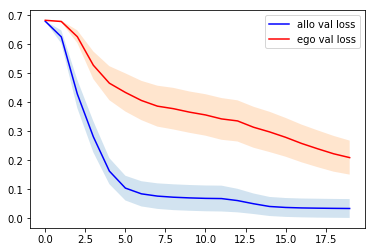

In [21]:
avlm,avls = calculate(info,0)
evlm,evls = calculate(ego_info,0)
plt.plot(avlm,color='b',label='allo val loss')
plt.fill_between(np.arange(20),avlm+avls,avlm-avls,alpha=0.2)

plt.plot(evlm,color='r',label='ego val loss')
plt.fill_between(np.arange(20),evlm+evls,evlm-evls,alpha=0.2)
#plt.ylabel('loss')
#plt.xlabel('Epoch')
plt.legend()

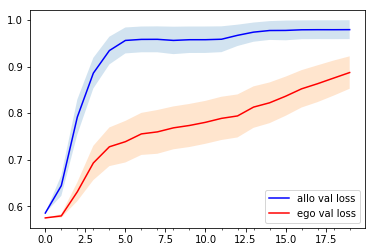

In [11]:
avlm,avls = calculate(info,1)
evlm,evls = calculate(ego_info,1)
ax= plt.subplot(1,1,1)
ax.plot(np.arange(20),avlm,color='b',label='allo val loss')
ax.fill_between(np.arange(20),avlm+avls,avlm-avls,alpha=0.2)
ax.plot(np.arange(20),evlm,color='r',label='ego val loss')
ax.fill_between(np.arange(20),evlm+evls,evlm-evls,alpha=0.2)
ax.set
ax.set_xticks(np.arange(20),minor=True)
ax.legend()

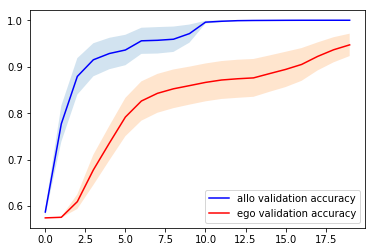

In [15]:
avam,avas = calculate(info,1)
evam,evas = calculate(ego_info,1)
plt.plot(avam,color='b',label='allo validation accuracy')
plt.fill_between(np.arange(20),avam+avas,avam-avas,alpha=0.2)
plt.plot(evam,color='r',label='ego validation accuracy')
plt.fill_between(np.arange(20),evam+evas,evam-evas,alpha=0.2)
atam,avas = calculate(info,3)
etam,evas = calculate(ego_info,3)
#plt.plot(atam,color='black',label='allo training accuracy')

#plt.plot(etam,color='r',label='ego training accuracy')

plt.legend()

In [38]:
c,x,z = createLayers(rest_size,conv_size,naction)

classifier = Model(inputs=[c,x],outputs=z)

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 21, 21, 5)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 21, 21, 6)    276         input_17[0][0]                   
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 2646)         0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
merge_9 (M

/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [39]:
ego_history = classifier.fit([all_simu['cnn_input'][:20000],all_simu['rest_input'][:20000]],all_simu['y'][:20000],epochs=10,batch_size=64,validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 5s 319us/step - loss: 0.6840 - acc: 0.5709 - val_loss: 0.6837 - val_acc: 0.5968
Epoch 2/10
16000/16000 [==============================] - 5s 291us/step - loss: 0.6824 - acc: 0.5741 - val_loss: 0.6772 - val_acc: 0.5972
Epoch 3/10
16000/16000 [==============================] - 5s 289us/step - loss: 0.6814 - acc: 0.5744 - val_loss: 0.6758 - val_acc: 0.5972
Epoch 4/10
16000/16000 [==============================] - 5s 294us/step - loss: 0.6785 - acc: 0.5757 - val_loss: 0.6702 - val_acc: 0.6025
Epoch 5/10
16000/16000 [==============================] - 5s 291us/step - loss: 0.6023 - acc: 0.6862 - val_loss: 0.5476 - val_acc: 0.7272
Epoch 6/10
16000/16000 [==============================] - 4s 276us/step - loss: 0.4707 - acc: 0.7772 - val_loss: 0.4028 - val_acc: 0.8127
Epoch 7/10
16000/16000 [==============================] - 4s 270us/step - loss: 0.2964 - acc: 0.8935 - val_loss: 0.2347 - v

### Train classifier attached to the trained network 

In [3]:
from keras.models import load_model,Model

Using TensorFlow backend.


In [4]:
all_simu = np.load('ego:{}_simulation_200000.npz'.format(Ego))

/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


(11, 11, 5) 5 (8,)


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 11, 11,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 11, 11,  276         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 100, 726)     0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 8)       0                                            
__________________________________________________________________________________________________
merge_1 (M

In [6]:
conv_mod = Model(inputs=[model.input[0],model.input[1]],outputs=[model.get_layer(index=4).output])
conv_mod.summary()
cnn_input = all_simu['cnn_input']
rest_input = all_simu['rest_input']
cnn_zeros = np.zeros((99,11,11,5))
rest_zeros = np.zeros((99,8))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 11, 11,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 11, 11,  276         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 100, 726)     0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 8)       0                                            
__________________________________________________________________________________________________
merge_1 (M

In [7]:
conv_data = np.zeros((cnn_input.shape[0],734))
for i in range(cnn_input.shape[0]):
    concated = np.concatenate([cnn_input[i][np.newaxis],cnn_zeros],axis=0)
    rest_concated = np.concatenate([rest_input[i][np.newaxis],rest_zeros],axis=0)
    conv_row = conv_mod.predict([concated[np.newaxis],rest_concated[np.newaxis]])
    conv_data[i] = conv_row[0,0]
np.save('conv_data.npy',conv_data)

In [8]:
FC1_mod = Model(inputs=[model.input[0],model.input[1]],outputs=[model.get_layer(index=5).output])
FC1_mod.summary()
FC1_data = np.zeros((cnn_input.shape[0],32))
for i in range(cnn_input.shape[0]):
    concated = np.concatenate([cnn_input[i][np.newaxis],cnn_zeros],axis=0)
    rest_concated = np.concatenate([rest_input[i][np.newaxis],rest_zeros],axis=0)
    conv_row = FC1_mod.predict([concated[np.newaxis],rest_concated[np.newaxis]])
    FC1_data[i] = conv_row[0,0]
np.save('FC1_data.npy',FC1_data)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 11, 11,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 11, 11,  276         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 100, 726)     0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 8)       0                                            
__________________________________________________________________________________________________
merge_1 (M

In [9]:
FC2_mod = Model(inputs=[model.input[0],model.input[1]],outputs=[model.get_layer(index=6).output])
FC2_mod.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 11, 11,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 11, 11,  276         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 100, 726)     0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 8)       0                                            
__________________________________________________________________________________________________
merge_1 (M

In [10]:
FC2_data = np.zeros((cnn_input.shape[0],32))
for i in range(cnn_input.shape[0]):
    concated = np.concatenate([cnn_input[i][np.newaxis],cnn_zeros],axis=0)
    rest_concated = np.concatenate([rest_input[i][np.newaxis],rest_zeros],axis=0)
    conv_row = FC2_mod.predict([concated[np.newaxis],rest_concated[np.newaxis]])
    FC2_data[i] = conv_row[0,0]
np.save('FC2_data.npy',FC1_data)

In [12]:
LSTM_mod = Model(inputs=[model.input[0],model.input[1]],outputs=[model.get_layer(index=7).output])
LSTM_mod.summary()

LSTM_data = np.zeros((cnn_input.shape[0],128))
for i in range(cnn_input.shape[0]):
    concated = np.concatenate([cnn_input[i][np.newaxis],cnn_zeros],axis=0)
    rest_concated = np.concatenate([rest_input[i][np.newaxis],rest_zeros],axis=0)
    conv_row = LSTM_mod.predict([concated[np.newaxis],rest_concated[np.newaxis]])
    LSTM_data[i] = conv_row[0,0]
np.save('LSTM_data.npy',FC1_data)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 11, 11,  0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 11, 11,  276         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 100, 726)     0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 8)       0                                            
__________________________________________________________________________________________________
merge_1 (M

In [7]:
final_data = np.zeros((cnn_input.shape[0],5))
for i in range(cnn_input.shape[0]):
    concated = np.concatenate([cnn_input[i][np.newaxis],cnn_zeros],axis=0)
    rest_concated = np.concatenate([rest_input[i][np.newaxis],rest_zeros],axis=0)
    conv_row = model.predict([concated[np.newaxis],rest_concated[np.newaxis]])
    final_data[i] = conv_row[0,0]
np.save('final.npy',final_data)